In [1]:
%%capture --no-stderr
%pip install --quiet -U langsmith langgraph tavily-python langchain_community python-dotenv langchain-core==0.3.21 pydantic==2.8.2 pydantic-settings==2.5.2 packaging==23.2 google-genai==0.3.0

In [66]:
import os
from IPython.display import Image, display
from google.genai import Client
from typing import Literal, Union, Dict
from langgraph.prebuilt import ToolNode
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from google.genai.types import Tool, GenerateContentConfig, GoogleSearch

In [49]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

client = Client(
  api_key=GOOGLE_API_KEY,
  http_options= {'api_version': 'v1alpha'}
)

MODEL: str = "gemini-2.0-flash-exp"

memory: MemorySaver = MemorySaver()


config = {
  "configurable": {"thread_id": "1"},
  "generation_config": {"response_modalities": ["TEXT"]}
  }

In [50]:
# State

class State(MessagesState):
    summary: str

In [76]:
google_search_tool = Tool(google_search=GoogleSearch())

# Example tool node integration
tool_node = ToolNode(tools=[google_search_tool])

In [52]:
# Summarization

async def summarize_conversation(state: State) -> Dict[str, object]:
    """
    Summarizes the conversation if the number of messages exceeds 6 messages.
    
    Args:
        state (State): The current conversation state.

    Returns:
        Dict[str, object]: A dictionary containing updated messages and the summary.
    """
    # Get any existing summary
    summary = state.get("summary", [])
    
    # Create the summarization prompt based on the presence of an existing summary
    if summary:
        summary_message = (
            f"This is the summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add the summarization prompt to the conversation history
    messages = [SystemMessage(content=summary_message)] + state["messages"]
    
    history_str = "\n".join([f"{m.type}: {m.content}" for m in messages])
    input_text = f"{history_str}\nUser: {summary_message}"

    async with client.aio.live.connect(model=MODEL, config=config) as session:
        await session.send(input=input_text, end_of_turn=True)
        turn = session.receive()
        response_text = ""

        async for chunk in turn:
            if chunk.text is not None:
                response_text += chunk.text

    # Update and return the new summary
    state["summary"] = response_text
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=getattr(m, "id", None)) for m in state["messages"][:-2]]

    return {"summary": response_text, "messages": delete_messages}

In [77]:
# Conditional Function

def select_next_node(state: State) -> Union[Literal["tools", "summarize"], str]:

    messages = state["messages"]
    last_message = messages[-1]

    # If there are more than six messages, route to "summarize_conversation"
    if len(messages) > 6:
        return "summarize"
    
    # If the LLM makes a tool call, route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    
    # Otherwise, route to "final" or end
    return END

In [82]:
async def call_model(state: State):
    """
    Handles the model invocation using the Gemini 2.0 Live API.
    
    Args:
        state (State): The current conversation state containing messages.

    Returns:
        Dict[str, Union[AIMessage, List[HumanMessage]]]: 
        The updated state with the model's response.
    """
    # Ensure state contains 'messages'
    if "messages" not in state:
        raise ValueError("State must contain a 'messages' key.")

    # Initialize messages from the state
    messages = state["messages"]

    # Extract the content from HumanMessage objects
    message_texts = [message.content for message in messages]

    # Prepend a summary if it exists
    summary = state.get("summary", "")
    if summary:
        message_texts.insert(0, f"Summary of conversation earlier: {summary}")

    # Use the Gemini 2.0 Live API
    async with client.aio.live.connect(model=MODEL, config=config) as session:
        try:
            # Send the conversation history as a single input
            await session.send(input=" ".join(message_texts), end_of_turn=True)

            # Receive the model's streamed response
            turn = session.receive()
            response_text = ""

            async for chunk in turn:
                if chunk.text is not None:
                    response_text += chunk.text

        except Exception as e:
            raise RuntimeError(f"Error invoking the model: {e}")
        
    

    # Append the response to messages
    response_message = AIMessage(content=response_text)
    messages.append(response_message)

    # Update and return the state
    return {"messages": messages, "last_message": response_message}

In [78]:
# Build Graph

builder = StateGraph(State)

builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)
builder.add_node("summarize", summarize_conversation)

builder.add_edge(START, "agent")
builder.add_edge("tools", "agent")
builder.add_edge("summarize", END)

builder.add_conditional_edges(
    "agent",
    select_next_node,
    {"summarize": "summarize", "tools": "tools", END: END},
)

graph = builder.compile(checkpointer=memory)

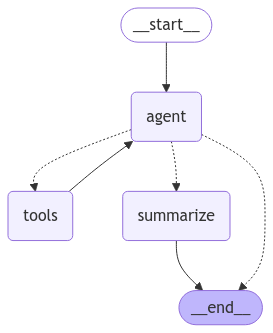

In [79]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [81]:
async def run(message:str):
    event = await graph.ainvoke({"messages": [HumanMessage(content=message)]}, config)
    return event

await run ("hi")

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='844388f5-0745-4bce-9ea6-e250a81a9693'),
  AIMessage(content='Okay, this continues the pattern perfectly. Here\'s a summary of the current interaction and why it\'s good:\n\n**Summary of the latest AI response:**\n\n*   **Acknowledgement:** The AI acknowledges Rida\'s request and uses their name.\n*   **Restatement of Limitation:** It clearly restates that it cannot access real-time weather data.\n*   **Apology:** The AI apologizes for not being able to fulfill the specific request directly.\n*   **Resource Provision:** It provides the same list of reliable resources (Google Weather, apps, websites) for Rida to get the information.\n*   **Explanation of Data:** It explains what type of information these resources provide (temperature, conditions, humidity, wind).\n*   **Reiteration of Limitation:** Again, the AI states it cannot provide the data directly.\n*   **Offer of Further Assistance:** The AI